<a href="https://colab.research.google.com/github/MRMRMRMAY/Advanced-Software-Analysis-202102/blob/main/Term%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import random
import sys

import numpy as np
from numpy import argwhere as findIdx
from scipy.spatial import distance_matrix, distance
from itertools import accumulate
from bisect import bisect_left
from copy import deepcopy
from statistics import mean, stdev
from scipy.stats.mstats import gmean
from math import exp
from time import process_time

In [3]:
# N = 50 # The 
M = 50 # The required number of cluster
K = 100 # The number of nodes, cannot be change
r = 100 # The radius of cluster region
round_crossover = K # The rounds of crossover
pro_mutation = 0.2 # The probability of executing mutation
size_pop = 1000 # The size of population for each generation
max_interval = 500 # The maximum interval between old and new best-so-far results.

In [17]:
class Ind:
    #initialize the attributes
    def __init__(self, distM, groups, r, M): #bound: random
        self.node_num = len(distM)
        self.groups = groups;
        self.radius = r
        self.calculateOverlap(distM)
        self.calculateFitness(M)
        self.hash = self.overlap
        # print(self.hash)

    #observe the overlap situation
    def calculateOverlap(self, distM):
        self.overlap = 0
        
        clusterHeader_idx = findIdx(self.groups == 1)
        clusterHeader_idx = clusterHeader_idx.reshape(len(clusterHeader_idx),)
        labels = np.zeros(self.node_num, )
        
        for idx in clusterHeader_idx:
            row = distM[idx,:]
            filtered_idx = findIdx(row <= self.radius)
            len_filtered_idx = len(filtered_idx)
            filtered_idx = filtered_idx.reshape(len_filtered_idx,)
            self.overlap = len_filtered_idx
            labels[filtered_idx] = 1
        self.overlap -= self.node_num
        self.error = len(findIdx(labels == 0))

    #calculates the fitness
    def calculateFitness(self, M):
        num_cluster = sum(self.groups)
        if self.error > 0:
            self.fitness = 0 - self.error * (K ** 3)
        elif num_cluster > M:
            self.fitness = (M - num_cluster) * (K ** 2)
        else:
            cluster_fit = num_cluster * K
            self.fitness = 0 - (cluster_fit + self.overlap)

    def __lt__(self, other):
        return self.fitness < other.fitness

    def __eq__(self, other):
        if (isinstance(other, Ind)):
            return self.groups == other.groups
        else:
            return False

In [ ]:
def FPS(pop):
  # random.shuffle(pop)
  sum_val = sum([idv.fitness for idv in pop])
  prob = list(accumulate([idv.fitness/sum_val for idv in pop]))
  return prob

def windowing_IFPS(pop):
  # random.shuffle(pop)
  beta = min(pop).fitness
  fitness = [idv.fitness - beta for idv in pop]
  sum_val = sum(fitness)
  prob = list(accumulate([f/sum_val for f in fitness]))
  return prob

def sigma_IFPS(pop):
  # random.shuffle(pop)
  fitness = [idv.fitness for idv in pop]
  mean_val = mean(fitness)
  var_val = stdev(fitness)
  c = 2
  for i in range(len(fitness)):
    fitness[i] = max(fitness[i] - (mean_val - c*var_val),0)
  sum_val = sum(fitness)
  prob = list(accumulate([f/sum_val for f in fitness]))
  return prob

def exp_rank(pop):
  pop.sort(reverse = True)
  len_pop = len(pop);
  sum_val = sum([1-exp(-i) for i in range(len_pop)])
  prob = list(accumulate([(1-exp(-i))/sum_val for i in range(len_pop)]))
  return prob

def linear_rank(pop, s):
  pop.sort(reverse = True)
  len_pop = len(pop)
  sum_val = sum([i for i in range(len_pop)])
  factor = (2 - s)/len_pop
  prob = list(accumulate([ factor + (i * (s - 1))/sum_val for i in range(len_pop)]))
  return prob

def roulette_wheel_sampling(lbd, pop, prob):
  r = random.random()
  idx1 = bisect_left(prob, r)
  # print(r, idx1)
  r = random.random()
  idx2 = bisect_left(prob, r)
  # print(r, idx2)
  return pop[idx1], pop[idx2]

def stochastic_sampling(lbd, pop, prob):
  r = random.uniform(0, 1/lbd)
  idx1 = bisect_left(prob, r)
  idx2 = bisect_left(prob, r+1/lbd)
  return pop[idx1], pop[idx2]

def tournamentSelection(pop, t_size):
  complete = lambda competitors: max(competitors)
  competitor1 = random.sample(pop, t_size)
  competitor2 = random.sample(pop, t_size)
  p1, p2 = complete(competitor1), complete(competitor2)
  return p1, p2


def load_data(fileName):
  X = np.loadtxt(fileName, delimiter=' ');
  return X;

# generate the matrix recording the distance between nodes
def calculate_disM(X):
  return distance_matrix(X, X, p = 2);

# generate the individual
def gen_indiv(distM, radius, K):
  global M
  new_groups = np.array(random.choices([0,1], k=K))
  return Ind(distM = distM, groups = new_groups, r = radius, M = M)

# generate the initial population
def gen_pop(popSize, distM, radius, K):
  return [gen_indiv(distM, radius, K) for i in range(popSize)];

def mutation(seq, K):
  pos1 = random.randint(0, K-1)
  pos2 = random.randint(0, K-1)
  while pos2 == pos1:
    pos2 = random.randint(0, K-1)
  seq[pos1], seq[pos2] = seq[pos2], seq[pos1]
  return seq

def crossover(p1, p2):
    len_seq = len(p1)
    r1 = r2 = 0
    while r1 == r2:
        r1, r2 = random.randint(0, len_seq), random.randint(0, len_seq)
    b = [r1, r2]
    b.sort()
    c1 = p1[0:b[0]] + p2[b[0]:b[1]] + p1[b[1]:]
    c2 = p2[0:b[0]] + p1[b[0]:b[1]] + p2[b[1]:]
    return np.array(c1), np.array(c2)

def selection(pop, prob = None):
  if prob == None:
      return tournamentSelection(pop, t_size = 2);
  else:
    #return stochastic_sampling(2, pop, prob);
      return roulette_wheel_sampling(2, pop, prob);

# the function executing the algorithm
def gen_algo():
    global size_pop, N, M, K, r, round_crossover, pro_mutation
    
    fileN = "./centroid_blobs_ILP.txt";
    X = load_data(fileN);
    distM = calculate_disM(X);
    
    good_num = int(0.5*size_pop)
    bad_num = size_pop - good_num

    pop = gen_pop(popSize = size_pop, distM = distM, radius = r, K = K);
    pop.sort(reverse = True)
    # time counter
    start = process_time()

    # record current optimal result
    OPT = -sys.maxsize
    OPT_clusterHeader = None

    # counting the interval
    interval = 0
    # counting the number of generations
    round = 0
    
    while max_interval > interval:
        round += 1
        nextPop = deepcopy(pop)
        # prob = linear_rank(pop, 1.5);
        # prob = exp_rank(pop);
        # prob = sigma_IFPS(pop);
        # prob = windowing_IFPS(pop);
        # prob = FPS(pop);
        for iid in range(round_crossover):
            #parent selection
            # p1, p2 = selection(pop, prob)
            p1, p2 = selection(pop)
            #crossover
            c1, c2 = crossover(list(p1.groups), list(p2.groups))
            ind1, ind2 = Ind(distM = distM, groups = c1, r = r, M = M), Ind(distM = distM, groups = c2, r = r, M = M)
            nextPop.append(ind1)
            nextPop.append(ind2)
            #mutation
            if random.random() >= pro_mutation:
                c1 = mutation(c1, K)
                ind1 = Ind(distM = distM, groups = c1, r = r, M = M)
                nextPop.append(ind1)
            if random.random() >= pro_mutation:
                c2 = mutation(c2, K)
                ind2 = Ind(distM = distM, groups = c2, r = r, M = M)
                nextPop.append(ind2)
        # nextPop = list(set(nextPop))
        nextPop.sort(reverse = True)
        # pop = nextPop[0:good_num] + nextPop[len(nextPop)-bad_num:]
        # pop = pop[0:pop_size]

        pop = nextPop[0:good_num] + random.sample(nextPop[good_num:], bad_num)
        pop.sort(reverse = True)
        
        interval += 1
        if OPT < pop[0].fitness:
            OPT = pop[0].fitness
            OPT_clusterHeader = pop[0].groups
            print("======="*20)
            print(f"Generation: {round}")
            print(f"The best-so-far fitness: {pop[0].fitness}")
            print(f"Time cost: {process_time() - start}")
            print(f"interval: {interval}")
            interval = 0
    centers = []
    for idx in range(len(OPT_clusterHeader)):
        if OPT_clusterHeader[idx] == 1:
            centers.append(X[idx])
    np.savetxt("./centers_second.txt", np.array(centers))

# the main function
def main():
  gen_algo()
  pass

if __name__ == "__main__":
  main()


Generation: 1
The best-so-far fitness: -2000000
Time cost: 0.3846596270000191
interval: 1
Generation: 6
The best-so-far fitness: -1000000
Time cost: 2.3530643520000467
interval: 5
Generation: 7
The best-so-far fitness: -120000
Time cost: 2.706081018999953
interval: 1
Generation: 10
The best-so-far fitness: -90000
Time cost: 4.022115437000025
interval: 3
Generation: 17
The best-so-far fitness: -80000
Time cost: 7.206265142999996
interval: 7
Generation: 20
The best-so-far fitness: -70000
Time cost: 8.996083848000012
interval: 3
Generation: 26
The best-so-far fitness: -60000
Time cost: 12.337818789000039
interval: 6
Generation: 33
The best-so-far fitness: -40000
Time cost: 16.02381203999994
interval: 7
Generation: 38
The best-so-far fitness: -30000
Time cost: 18.331797307999977
interval: 5
Generation: 40
The best-so-far fitness: -20000
Time cost: 19.65403073699997
interval: 2
Generation: 45
The best-so-far fitness: -10000
Time cost: 21.7495222
interval: 5
Generation: 46
The best-so-far fi

38


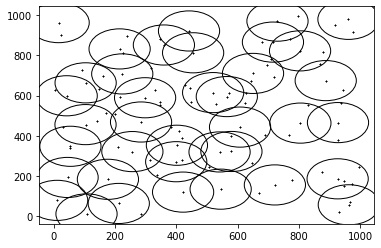

In [16]:
import matplotlib.pyplot as plt
X = load_data("./centroid_blobs_ILP.txt")
centers = load_data("./centers_second.txt")
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[:,0], X[:,1], c='black', marker='x', s = 1)
for center in centers:
    disk1 = plt.Circle((center[0], center[1]), 100, color='black', fill=False)
    ax.add_artist(disk1)
plt.show();